In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
from urllib.request import urlopen

urls = {'pneumothorax_test':'https://www.dropbox.com/s/x74ykyivipwnozs/pneumothorax_test.h5?dl=1',
        'pneumothorax_train':'https://www.dropbox.com/s/pnwf67qzztd1slc/pneumothorax_train.h5?dl=1'}

for (name,url) in urls.items():
        print('Downloading '+name+'...')
        u = urlopen(url)
        data = u.read()
        u.close()

        with open(name+'.h5', "wb") as f :
            f.write(data)
print('Files have been downloaded.')

Files have been downloaded.


In [0]:
import h5py as h5

X_train = h5.File('pneumothorax_train.h5')['image'][:]
Y_train = h5.File('pneumothorax_train.h5')['label'][:]

X_test = h5.File('pneumothorax_test.h5')['image'][:]
Y_test = h5.File('pneumothorax_test.h5')['label'][:]

In [4]:
num_train=X_train.shape[0]
num_test=X_test.shape[0]
X_train.shape

(8064, 256, 256, 1)

In [0]:
from keras.models import Model,Sequential
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.layers.convolutional import Conv2D,SeparableConv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Flatten,GlobalAveragePooling2D
from keras.layers import Dense,Input
from keras.layers import Activation
from keras.layers import Dropout
from keras.optimizers import SGD,Adadelta
from keras.optimizers import Adagrad
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import tensorflow as tf

In [0]:
seed=1337
np.random.seed(seed)

In [7]:
X_train = (X_train/255).astype('float32')
X_test = (X_test/255).astype('float32')
Y_train = Y_train.astype('float32')
Y_test = Y_test.astype('float32')
num_class=2
X_train.shape[1:]

(256, 256, 1)

In [0]:
inputs=Input(shape=(256,256,1))
  
x=Conv2D(32, (5,5), padding='same',kernel_initializer='random_uniform', activation='relu')(inputs)
y=Conv2D(32, (5,5), padding='same', kernel_initializer='random_uniform',activation='relu')(x)
z=MaxPooling2D(pool_size=(2,2))(keras.layers.add([x,y]))
  
x=Conv2D(64, (5,5), padding='same',kernel_initializer='random_uniform', activation='relu')(z)
y=Conv2D(64, (5,5), padding='same',kernel_initializer='random_uniform', activation='relu')(x)
z=MaxPooling2D(pool_size=(2,2))(keras.layers.add([x,y]))
  
x=SeparableConv2D(128, (5,5), padding='same',kernel_initializer='random_uniform', activation='relu')(z)
y=SeparableConv2D(128, (5,5), padding='same',kernel_initializer='random_uniform', activation='relu')(x)
z=MaxPooling2D(pool_size=(2,2))(keras.layers.add([x,y]))
  
x=Conv2D(256, (3,3), padding='same',kernel_initializer='random_uniform', activation='relu')(z)
y=Conv2D(256, (3,3), padding='same',kernel_initializer='random_uniform', activation='relu')(x)
y=Conv2D(256, (3,3), padding='same',kernel_initializer='random_uniform', activation='relu')(y)
z=MaxPooling2D(pool_size=(2,2))(keras.layers.add([x,y]))

z=GlobalAveragePooling2D()(z)

x=Dense(64,activation='relu',)(z)
x=Dense(2,activation='sigmoid',kernel_initializer='random_uniform')(x)

model=Model(inputs = inputs, outputs = x)
#step 2: Learning target(computiong the loss using the entropy function
sgd = SGD(lr=0.06, decay=1e-6, momentum=0.9, nesterov=True)

adagrad = Adagrad(lr=0.05, epsilon=1e-08)
opt = Adadelta(lr=1.0, rho=0.95, epsilon=0.0001, decay=0.000001)
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [0]:
#To load the already trained weights from current model
model.load_weights('weights.h5')

---
### You will need *GPU* power to Train this Model. But weights have been provided to you, so if you want you can Skip the Training Process!!


---



In [0]:
print ('Training Start....')
#reset_weights(model)
training = model.fit(X_train,Y_train, batch_size=90,epochs=100,verbose=1, validation_data=(X_test, Y_test),shuffle=False)

In [49]:
model.summary()
model.to_json()
model.save_weights('weights.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_46 (Conv2D)              (None, 256, 256, 32) 832         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_47 (Conv2D)              (None, 256, 256, 32) 25632       conv2d_46[0][0]                  
__________________________________________________________________________________________________
add_6 (Add)                     (None, 256, 256, 32) 0           conv2d_46[0][0]                  
                                                                 conv2d_47[0][0]                  
__________

In [0]:
#To Download Produced Weights from Google Colab
from google.colab import files
files.download('weights.h5')

In [0]:
score = model.evaluate(X_test,Y_test,verbose=1)
print("CNN Error: %.2f%%" % (100-score[1]*100))
'CNN Accuracy: %.2f%%' % (score[1]*100)

0


array([[9.9998784e-01, 1.9116023e-05]], dtype=float32)

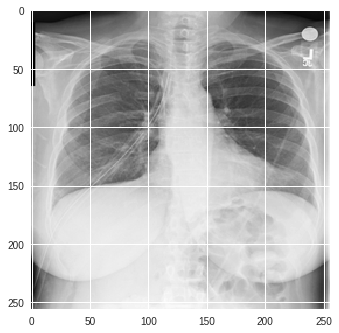

In [40]:
plt.imshow(X_test[1200,:,:,0],cmap='gray')
print(np.argmax(Y_test[1200]))
test=X_test[1200]
test=test.reshape(1,256,256,1)
model.predict(test)

In [41]:
from sklearn.metrics import roc_curve,auc
print(Y_test.shape)

(1900, 2)


In [42]:
y_pred=model.predict(X_test)
print(y_pred.shape)
fpr, tpr, thresholds = roc_curve(Y_test.argmax(axis=1),y_pred.argmax(axis=1))

(1900, 2)


In [0]:
auc=auc(fpr, tpr)

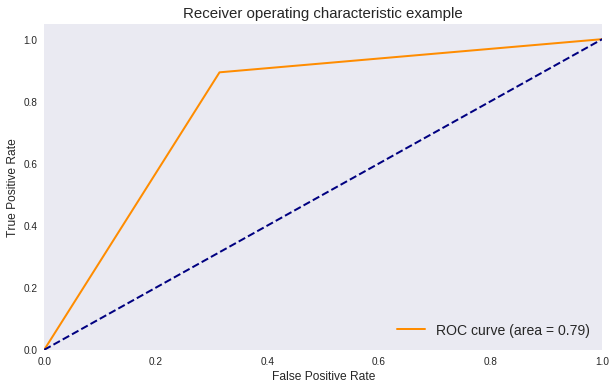

In [44]:
plt.figure(figsize=(10,6))
plt.grid()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver operating characteristic example', fontsize=15)
plt.legend(loc="lower right", fontsize=14)
plt.show()